# Step 0: 固定随机种子

# Step 1: Load data

In [1]:
#!/usr/bin/env python
# -*- coding: utf-8 -*-
import numpy as np
import torch
import random

# Step 0: 固定随机种子
seed = 42
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
print(f"✅ 已设置随机种子: {seed}")


import sys
sys.path.append("/home/vs_theg/ST_program/cell_program_deconvolution/cell_program_deconvolution/")  # 添加上级目录到Python路径
from deconvolution.model import DeconvModel
from deconvolution.graph_utils import build_laplacian
from deconvolution.train import train_model
from deconvolution.visualize import plot_spatial, plot_program_contribution

sys.path.append("/home/vs_theg/ST_program/CellType_GP/CellType-GP")  # 添加上级目录到Python路径
from train_utils import train_model_2

# Step 1: Load data
data = np.load("/home/vs_theg/ST_program/CellType_GP/DATA/preprocessing_outputs/spot_data_full.npz", allow_pickle=True)
Y = torch.tensor(data["visium_score"], dtype=torch.float32)         # (P, S)
X = torch.tensor(data["spot_cluster_fraction_matrix"], dtype=torch.float32)         # (S, T)
coords = data["coords"]                                  # (S, 2)

spot_names = data['spot_names']
celltype_names = data['celltype_names']
program_names = data['program_names']

# 查看数据前几行
print("Y (shape: {}):".format(Y.shape))
print(Y[:5, :5])  # 查看前5行前5列
print("\nX (shape: {}):".format(X.shape))
print(X[:5, :5])  # 查看前5行前5列
print("\ncoords (shape: {}):".format(coords.shape))
print(coords[:5])  # 查看前5行

P, S = Y.shape
S_, T = X.shape
assert S == S_

L = build_laplacian(coords, k=6)
model = DeconvModel(T=T, P=P, S=S, X_tensor=X, L=L)


✅ 已设置随机种子: 42
Y (shape: torch.Size([13, 3953])):
tensor([[0.2741, 0.2692, 0.2627, 0.1067, 0.5122],
        [0.2596, 0.2071, 0.3248, 0.0480, 0.1580],
        [0.2877, 0.6234, 0.3451, 0.2823, 0.2601],
        [0.2727, 0.3972, 0.2551, 0.4064, 0.2967],
        [0.3123, 0.5241, 0.4290, 0.3826, 0.3049]])

X (shape: torch.Size([3953, 7])):
tensor([[0.0714, 0.0000, 0.0000, 0.0000, 0.0714],
        [0.0000, 0.1064, 0.2128, 0.0000, 0.1702],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.2222, 0.0000, 0.1111],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0455]])

coords (shape: (3953, 2)):
[[13355. 16640.]
 [ 8845. 12067.]
 [14716. 15518.]
 [11404. 12365.]
 [ 7452.  9059.]]


## 检查拉普拉斯矩阵的半正定性

In [2]:
eigvals = torch.linalg.eigvalsh(L)
print(eigvals.min().item(), eigvals.max().item(), torch.allclose(L, L.T, atol=1e-6))
# 输出最小特征值、最大特征值、对称性检查结果，确保拉普拉斯矩阵L是半正定的

4.77342325666541e-08 1.4985675811767578 True


# Step 2: Train model

In [3]:
import os
os.chdir('/home/vs_theg/ST_program/CellType_GP/DATA')

In [4]:
# Step 2: Train model
# train_model(model,  Y_obs=Y, num_epochs=6000, lr=1e-4, lambda1=0, lambda2=0)

# 若需step5, 可取消下一行注释训练
history = train_model_2(model,  Y_obs=Y, num_epochs=3000, lr=1e-3, lambda1=1e-6, lambda2=1e-6)

Epoch    0 | Loss 0.3318 | Recon 0.1220 | LR 1.00e-03:   0%|       | 1/3000 [00:01<58:56,  1.18s/it]

🔍 [中间层检查] Epoch 0
  Y_tps  mean=4.988538e-01, std=2.885916e-01
  Y_pred mean=4.984032e-01, std=2.240942e-01


Epoch  501 | Loss 0.0904 | Recon 0.0136 | LR 1.00e-03:  17%|▊    | 502/3000 [02:12<06:40,  6.23it/s]

🔍 [中间层检查] Epoch 500
  Y_tps  mean=1.831981e-01, std=1.927531e-01
  Y_pred mean=3.068680e-01, std=1.383651e-01


Epoch 1001 | Loss 0.0318 | Recon 0.0039 | LR 1.00e-03:  33%|█▎  | 1002/3000 [04:23<08:07,  4.10it/s]

🔍 [中间层检查] Epoch 1000
  Y_tps  mean=7.016256e-02, std=1.535816e-01
  Y_pred mean=2.535684e-01, std=1.455008e-01


Epoch 1500 | Loss 0.0271 | Recon 0.0034 | LR 1.00e-03:  50%|██  | 1501/3000 [06:30<05:41,  4.39it/s]

🔍 [中间层检查] Epoch 1500
  Y_tps  mean=5.932495e-02, std=1.576878e-01
  Y_pred mean=2.430560e-01, std=1.540780e-01


Epoch 2001 | Loss 0.0269 | Recon 0.0034 | LR 1.00e-03:  67%|██▋ | 2002/3000 [09:07<05:13,  3.18it/s]

🔍 [中间层检查] Epoch 2000
  Y_tps  mean=5.857882e-02, std=1.601720e-01
  Y_pred mean=2.417169e-01, std=1.562946e-01


Epoch 2500 | Loss 0.0268 | Recon 0.0033 | LR 1.00e-03:  83%|███▎| 2501/3000 [10:48<05:02,  1.65it/s]

🔍 [中间层检查] Epoch 2500
  Y_tps  mean=5.850534e-02, std=1.612459e-01
  Y_pred mean=2.417067e-01, std=1.566362e-01


Epoch 2999 | Loss 0.0268 | Recon 0.0033 | LR 6.25e-05: 100%|████| 3000/3000 [12:41<00:00,  3.94it/s]



✅ 训练完成：最优loss=0.026784，最优epoch=2976
📉 Loss曲线已保存至: ./training_logs/loss_curve.png
📝 训练日志已保存至: ./training_logs/train_log.txt


In [5]:
print(history)

{'total_loss': array([0.33182609, 0.33093384, 0.33004373, ..., 0.02678308, 0.0267831 ,
       0.02678316]), 'recon_loss': array([0.1220348 , 0.1214852 , 0.12093758, ..., 0.00333915, 0.00333915,
       0.00333915]), 'l1_loss': array([179745.421875  , 179449.328125  , 179153.265625  , ...,
        21037.58007812,  21037.60351562,  21037.65234375]), 'smooth_loss': array([30045.85742188, 29999.32226562, 29952.89453125, ...,
        2406.34863281,  2406.3503418 ,  2406.3527832 ]), 'lr': array([1.00e-03, 1.00e-03, 1.00e-03, ..., 6.25e-05, 6.25e-05, 6.25e-05]), 'best_loss': 0.026784099638462067, 'best_epoch': 2976}


# Step 3: 生成最终预测结果 Y_pred_df


In [ ]:
import torch
import numpy as np
import pandas as pd

# Step 3: 生成最终预测结果
with torch.no_grad():
    Y_pred = model.forward().detach().cpu().numpy()  # shape: (P, S)

# 转置成 (S, P) 方便与 spot 对齐
Y_pred_df = pd.DataFrame(Y_pred.T, index=data['spot_names'], columns=data['program_names'])

output_path_pred = '/home/vs_theg/ST_program/CellType_GP/DATA/training_logs/2/train_result(pred_matrix).csv'
Y_pred_df.to_csv(output_path_pred)
print(f"✅ 已生成预测矩阵：{Y_pred_df.shape}")
print(f"👉 保存路径: {output_path_pred}")


✅ 已生成预测矩阵：(3953, 13)
👉 保存路径: /home/vs_theg/ST_program/CellType_GP/DATA/training_logs/2/train_result(pred_matrix).csv


In [12]:
Y_pred_df

,B_cell_score,T_cell_score,DCIS_Tumor_score,Endothelial_score,Invasive_Tumor_score,IRF7+_DCs_score,LAMP3+_DCs_score,Macrophages_score,Mast_score,Myoepi_ACTA2+_score,Myoepi_KRT15+_score,Perivascular-Like_score,Stromal_score
AACACGTGCATCGCAC-1,0.263184,0.236851,0.269044,0.249916,0.294433,0.329594,0.191768,0.379541,0.374315,0.163260,0.112335,0.306031,0.597678
AACACTTGGCAAGGAA-1,0.178092,0.115761,0.520098,0.297038,0.424004,0.214213,0.216995,0.317991,0.100023,0.628222,0.321257,0.336076,0.262981
AACAGGAAGAGCATAG-1,0.244506,0.295717,0.319213,0.237149,0.400005,0.268155,0.401342,0.461321,0.381442,0.368088,0.231021,0.396876,0.467534
AACAGGATTCATAGTT-1,0.065456,0.008819,0.223596,0.326596,0.323090,0.101495,0.182028,0.264565,0.189444,0.176289,0.128477,0.237649,0.511249
AACAGGTTATTGCACC-1,0.478205,0.135724,0.233122,0.276966,0.280685,0.298957,0.385464,0.496176,0.222918,0.226796,0.177975,0.275759,0.632684
...,...,...,...,...,...,...,...,...,...,...,...,...,...
TGTTGGAACCTTCCGC-1,0.207556,0.090414,0.239019,0.247323,0.336919,0.140873,0.109936,0.330446,0.074751,0.320056,0.080961,0.270881,0.498904
TGTTGGAACGAGGTCA-1,0.053648,0.087239,0.269172,0.379428,0.248422,0.202569,0.245848,0.440333,0.166364,0.282873,0.182815,0.370540,0.515469
TGTTGGAAGCTCGGTA-1,0.363379,0.417044,0.368332,0.307782,0.392161,0.367099,0.191787,0.484265,0.129281,0.329200,0.147880,0.273766,0.319759
TGTTGGATGGACTTCT-1,0.157875,0.157544,0.436895,0.198952,0.623517,0.179264,0.177059,0.308028,0.017443,0.226252,0.147727,0.211123,0.233290


# Step 4: 可视化结果

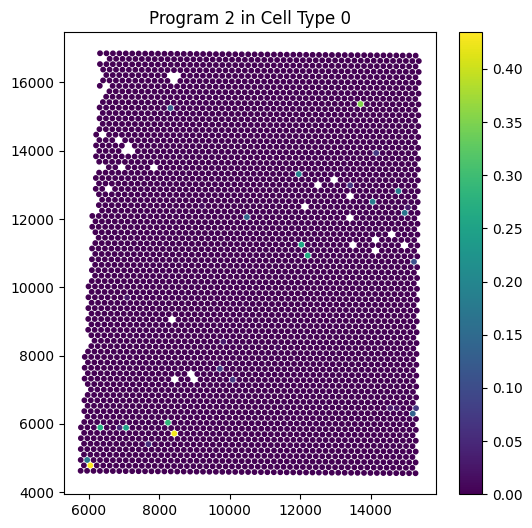

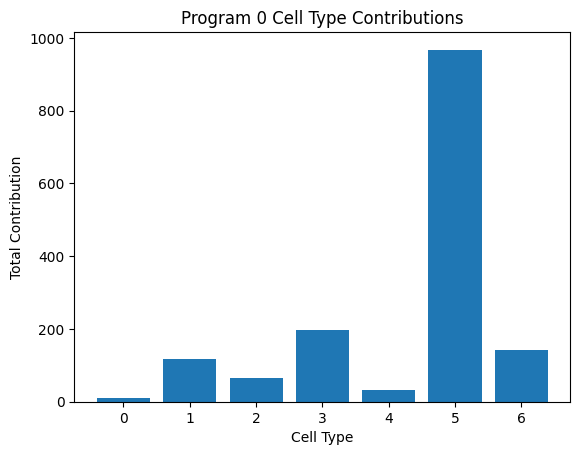

✅ 已生成矩阵表：3953 × 91
👉 保存路径: /home/vs_theg/ST_program/CellType_GP/DATA/notebook_outputs/train1000_342_result(wide).csv


In [ ]:
# Step 4: Visualize results
Y_tps = model.Y_tps.detach()
plot_spatial(Y_tps, coords, cell_type=0, program_index=2)
plot_program_contribution(Y_tps, program_index=0)


import numpy as np
import pandas as pd


# Step 5: Convert Y_tps to wide DataFrame and save
# 假设 Y_tps 形状为 (T, P, S)
Y_tps = model.Y_tps.detach().cpu().numpy()
T, P, S = Y_tps.shape

# 确保索引
spot_names = data['spot_names']
celltype_names = data['celltype_names']
program_names = data['program_names']


# 1️⃣ 重新排列维度： (S, T, P)
Y_tps_reordered = np.transpose(Y_tps, (2, 0, 1))  # S x T x P

# 2️⃣ 展平每个 spot 的 (T×P) 向量
Y_tps_flat = Y_tps_reordered.reshape(S, T * P)

# 3️⃣构造 DataFrame
columns = [f"{ct}+{pg}" for ct in celltype_names for pg in program_names]
y_tps_matrix_df = pd.DataFrame(Y_tps_flat, index=spot_names, columns=columns)

# 4️⃣ 保存结果
output_path = '/home/vs_theg/ST_program/CellType_GP/DATA/notebook_outputs/train1000_342_result(wide).csv'
y_tps_matrix_df.to_csv(output_path, index=True)
print(f"✅ 已生成矩阵表：{y_tps_matrix_df.shape[0]} × {y_tps_matrix_df.shape[1]}")
print(f"👉 保存路径: {output_path}")



In [ ]:
Convert Y_tps to wide DataFrame and save
# 假设 Y_tps 形状为 (T, P, S)
Y_tps = model.Y_tps.detach().cpu().numpy()
T, P, S = Y_tps.shape

# 确保索引
spot_names = data['spot_names']
celltype_names = data['celltype_names']
program_names = data['program_names']


# 1️⃣ 重新排列维度： (S, T, P)
Y_tps_reordered = np.transpose(Y_tps, (2, 0, 1))  # S x T x P

# 2️⃣ 展平每个 spot 的 (T×P) 向量
Y_tps_flat = Y_tps_reordered.reshape(S, T * P)

# 3️⃣构造 DataFrame
columns = [f"{ct}+{pg}" for ct in celltype_names for pg in program_names]
y_tps_matrix_df = pd.DataFrame(Y_tps_flat, index=spot_names, columns=columns)

# 4️⃣ 保存结果
output_path = '/home/vs_theg/ST_program/CellType_GP/DATA/notebook_outputs/train1000_342_result(wide).csv'
y_tps_matrix_df.to_csv(output_path, index=True)
print(f"✅ 已生成矩阵表：{y_tps_matrix_df.shape[0]} × {y_tps_matrix_df.shape[1]}")
print(f"👉 保存路径: {output_path}")



In [7]:
print(y_tps_matrix_df.head())

                    B_Cells+B_cell_score  B_Cells+T_cell_score  \
AACACGTGCATCGCAC-1              0.000001             -0.000005   
AACACTTGGCAAGGAA-1              0.000006              0.000010   
AACAGGAAGAGCATAG-1             -0.000006             -0.000007   
AACAGGATTCATAGTT-1              0.000010             -0.000002   
AACAGGTTATTGCACC-1              0.000003             -0.000021   

                    B_Cells+DCIS_Tumor_score  B_Cells+Endothelial_score  \
AACACGTGCATCGCAC-1                  0.000009                   0.000004   
AACACTTGGCAAGGAA-1                  0.000004                   0.000004   
AACAGGAAGAGCATAG-1                 -0.000008                   0.000015   
AACAGGATTCATAGTT-1                 -0.000003                   0.000026   
AACAGGTTATTGCACC-1                 -0.000012                  -0.000015   

                    B_Cells+Invasive_Tumor_score  B_Cells+IRF7+_DCs_score  \
AACACGTGCATCGCAC-1                     -0.000006                 0.000013  

# Step 5: Plot loss curve

In [8]:
# Step 5: Plot loss curve
import matplotlib.pyplot as plt
import numpy as np

history = np.array(history)
total_loss = history[:, 0]
recon_loss = history[:, 1]

plt.figure(figsize=(7,4))
plt.plot(total_loss, label='Total Loss', linewidth=1.5)
plt.plot(recon_loss, label='Reconstruction Loss', linewidth=1.5)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss Curve')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.savefig("loss_curve.png", dpi=300)
plt.show()



IndexError: too many indices for array: array is 0-dimensional, but 2 were indexed